In [2]:
from torch.utils.data import Dataset, DataLoader
from torch import tensor
from torch import optim
import torch
from torchvision import models, transforms
from torch import nn, transpose
from skimage import io, transform
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import copy
import time

In [3]:
df = pd.read_csv('/mnt/d/uczelnia/magister/TCGA_breast_patch/metadata.csv')

In [4]:
df.head()

,Unnamed: 0,file_name,label
0,1502,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+
1,1503,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+
2,1504,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+
3,1505,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+
4,1506,/mnt/d/uczelnia/magister/TCGA_breast_patch/TCG...,hr+her2+


In [5]:
label2id = {v: i for i, v in enumerate(df['label'].value_counts().index)}
id2label = {i: v for i, v in enumerate(df['label'].value_counts().index)}

In [6]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [7]:
class ImageDataset(Dataset):
    def __init__(self, paths, labels, label2id, transform=None):
        self.paths = paths
        self.labels = labels
        self.label2id = label2id
        self.transform = transform

    def __getitem__(self, idx):
        image = io.imread(self.paths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
            
        sample = {
            'inputs': image,
            'labels': self.label2id[label]
        }
        return sample

    def __len__(self):
        return len(self.labels)

In [8]:
def get_train_test_split(df: pd.DataFrame, test_group_sample_size: int=400, train_group_sample_size: int = None, target_column: str="label"):
    test_df = pd.DataFrame(columns=df.columns)
    for c in df[target_column].unique():
        test_df = pd.concat([df[df[target_column] == c].sample(test_group_sample_size, random_state=420).loc[:], test_df.loc[:]])
    train_df = df.loc[~df.index.isin(test_df.index)]
    
    if train_group_sample_size:
        train_df2 = pd.DataFrame(columns=df.columns)
        # max_sample = np.min(df['label'].value_counts().iloc[0:3].to_numpy())
        for c in df[target_column].unique():
            train_df2 = pd.concat([df[df[target_column] == c].sample(train_group_sample_size, random_state=420).loc[:], train_df2.loc[:]])
        train_df = train_df2

    return train_df, test_df

train_df, val_df = get_train_test_split(df, train_group_sample_size=10000)
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
print(train_df.shape, val_df.shape)

(30000, 4) (1200, 4)


In [9]:
# train_dataset = ImageDataset(train_df['file_name'], train_df['label'], label2id)
# val_dataset = ImageDataset(val_df['file_name'], val_df['label'], label2id)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# fig = plt.figure()

# for i, sample in enumerate(train_dataset):
#     print(i, sample['image'].shape)

#     ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     plt.imshow(sample['image'])

#     if i == 3:
#         plt.show()
#         break

In [9]:
class ImageClassifier(nn.Module):
    def __set_parameter_requires_grad(self, model):
        for param in model.parameters():
            param.requires_grad = False
            
    def __init__(self, num_classes):
        super(ImageClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.__set_parameter_requires_grad(self.resnet)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        
    def forward(self, input):
        input = input.float()
        out = self.resnet(input)

        return nn.functional.softmax(out, dim=1)

In [15]:
import shutil, sys   
def save_ckp(state, checkpoint_path, best_model_path=None):
    """
    state: checkpoint we want to save
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    is_best: is this the best checkpoint; min validation loss
    """
    f_path = checkpoint_path
    torch.save(state, f_path)
    
    if best_model_path is not None:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [11]:
def train_model(dataloaders, num_epochs=25):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    loss_fn = nn.CrossEntropyLoss()
    model = ImageClassifier(len(label2id.keys())).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    since = time.time()

    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for d in dataloaders[phase]:
                # print(inputs, labels)
                inputs = d['inputs'].to(device)
                labels = d['labels'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            elif phase == 'train':
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
print(train_df['file_name'].index)

RangeIndex(start=0, stop=712971, step=1)


In [12]:
train_dataset = ImageDataset(train_df['file_name'], train_df['label'], label2id, data_transforms)
val_dataset = ImageDataset(val_df['file_name'], val_df['label'], label2id, data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)


dataLoaders = {'val': val_loader, 'train': train_loader}
model, val_acc_history = train_model(dataLoaders)

/home/swietjak/mgr/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/swietjak/mgr/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


/home/swietjak/mgr/env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train Loss: 1.0537 Acc: 0.4478
val Loss: 1.0295 Acc: 0.4750

Epoch 1/24
----------
train Loss: 1.0347 Acc: 0.4803
val Loss: 1.0239 Acc: 0.4900

Epoch 2/24
----------
train Loss: 1.0294 Acc: 0.4862
val Loss: 1.0237 Acc: 0.4883

Epoch 3/24
----------
train Loss: 1.0271 Acc: 0.4895
val Loss: 1.0148 Acc: 0.5067

Epoch 4/24
----------
train Loss: 1.0247 Acc: 0.4913
val Loss: 1.0285 Acc: 0.4867

Epoch 5/24
----------
train Loss: 1.0229 Acc: 0.4932
val Loss: 1.0132 Acc: 0.5167

Epoch 6/24
----------
train Loss: 1.0195 Acc: 0.4976
val Loss: 1.0152 Acc: 0.4983

Epoch 7/24
----------
train Loss: 1.0209 Acc: 0.4971
val Loss: 1.0133 Acc: 0.5142

Epoch 8/24
----------
train Loss: 1.0185 Acc: 0.5004
val Loss: 1.0146 Acc: 0.5175

Epoch 9/24
----------
train Loss: 1.0199 Acc: 0.4961
val Loss: 1.0116 Acc: 0.5175

Epoch 10/24
----------
train Loss: 1.0198 Acc: 0.4979
val Loss: 1.0086 Acc: 0.5100

Epoch 11/24
----------
train Loss: 1.0193 Acc: 0.4970
val Loss: 1.0031 Acc: 0.5242

Epoch 12/24
----------
t

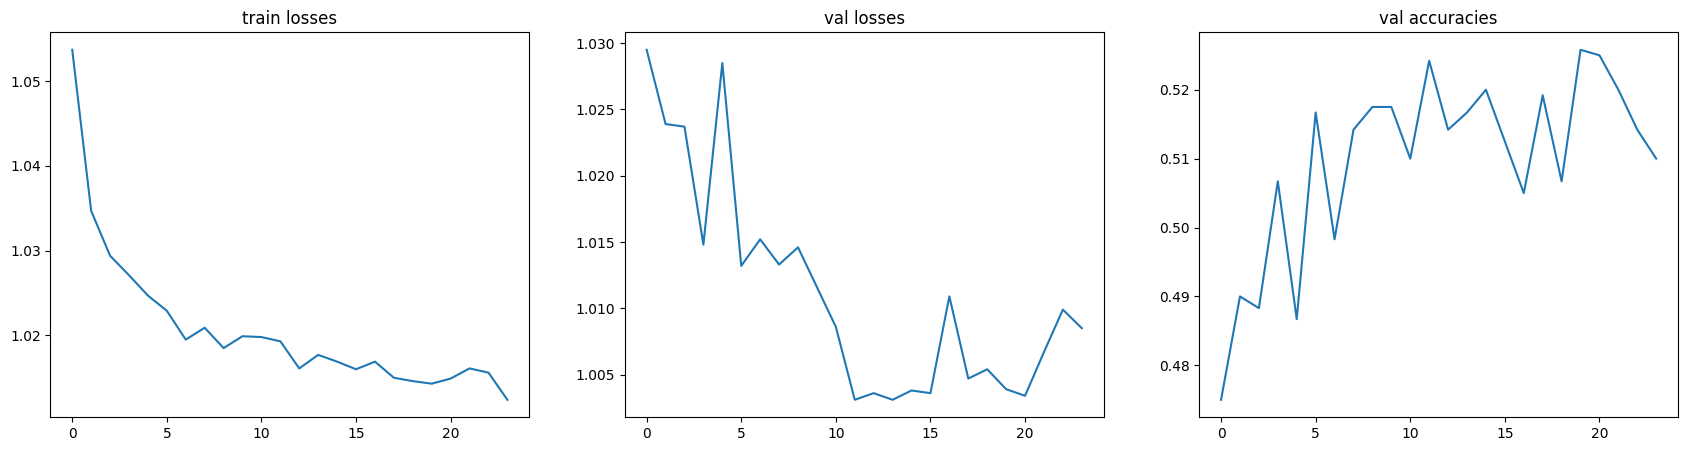

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 5))

axs[0].title.set_text('train losses')
axs[0].plot([1.0537,
1.0347,
1.0294,
1.0271,
1.0247,
1.0229,
1.0195,
1.0209,
1.0185,
1.0199,
1.0198,
1.0193,
1.0161,
1.0177,
1.0169,
1.0160,
1.0169,
1.0150,
1.0146,
1.0143,
1.0149,
1.0161,
1.0156,
1.0124])

axs[1].title.set_text('val losses')
axs[1].plot([1.0295,
1.0239,
1.0237,
1.0148,
1.0285,
1.0132,
1.0152,
1.0133,
1.0146,
1.0116,
1.0086,
1.0031,
1.0036,
1.0031,
1.0038,
1.0036,
1.0109,
1.0047,
1.0054,
1.0039,
1.0034,
1.0067,
1.0099,
1.0085])

axs[2].title.set_text('val accuracies')
axs[2].plot([0.4750,
0.4900,
0.4883,
0.5067,
0.4867,
0.5167,
0.4983,
0.5142,
0.5175,
0.5175,
0.5100,
0.5242,
0.5142,
0.5167,
0.5200,
0.5125,
0.5050,
0.5192,
0.5067,
0.5258,
0.5250,
0.5200,
0.5142,
0.5100])


In [17]:
save_ckp(model, checkpoint_path='checkpoints/resnet/base_resnet.pt')